<H1>TwoSlit</H1> 
Emulate TwoSlit Experiment using qiskit, 
<hr>
<H2>Modification history </H2><br> 
<table>
    <tr>
        <th> Modified </th>
        <th> By </th>
        <th> Reason </th>
    </tr>
    <tr> 
        <td> 07-Apr-25 </td>
        <td> CBL </td> 
        <td> Original </td>
    </tr>
    <tr> 
        <td> 17-Apr-25 </td>
        <td> CBL </td> 
        <td> Clean up a bit with some more documentation </td>
    </tr>
    <tr> 
        <td> 24-Jul-25 </td>
        <td> CBL </td> 
        <td> V2.1 Change from Sampler to Estimator for real amplitudes.  Also call out AER as the simulator. </td>
    </tr>
</table>
<hr> 
<H2> References </H2> 
<a href="https://docs.quantum.ibm.com/guides/install-qiskit"> Install Qikit </a> <br> 
<a href="https://docs.quantum.ibm.com/guides/hello-world"> qiskit hello world </a> <br> 
<a href="https://qiskit-community.github.io/qiskit-dynamics/"> Qiskit dynamics</a> <br> 
<a href="https://pypi.org/project/qiskit/"> Pypi qiskit page</a> <br> 
<a href="https://docs.quantum.ibm.com/api/qiskit/visualization"> Visualization</a> <br> 
<hr>
<H2> Notes </H2>
Hit every cell in order to get this to work. I may be overloaded on imports. This was a first pass. <br> 
If you want to run this on a real processor, you need to apply for an account and get a token. <br> 
This example uses the AER simulator package. <br> 
<br> 

In [3]:
# my standard includes
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as const
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli
from scipy.spatial.transform import Rotation as R

<H1> Basic Concepts </H1>
What we are trying to accomplish is how to encode a physics problem into a gate based 
notation to program a quantum computer. We start with the classic Two Slit problem. <br> 
<center> <img src="Pics/Double-Slit-Experiment-Results-768x538.png" width=300 height=300>
 </center>
<!-- source https://energywavetheory.com/explanations/double-slit-experiment/ -->
<br> 
The figure shows particles which we are more interested in. This is demonstrated classically with
light, but it has been experimentally verified that photons exhibit the same behaviour, as do electrons, protons and other particles. The puzzling part is that for single quanta, that the pattern still exists. This experimentally verifies that a quanta can interfere with itself. 
Taking a quantum bit, qubit, and applying a Hadamard gate to it, causes superposition of the
qubit emulating the properties of the quanta (photon, electron, etc.) <br> 

Another way to look at this problem is to consider what is called the Mach-Zender interferometer. 
Geometrically, this setup is identical to the the double slit problem. 

<center> <img src="Pics/image-png-Feb-13-2024-03-30-15-8528-PM.png" width=300 height=300 > </center>
<!-- source https://blog.ozeninc.com/resources/model-an-interferometer-in-zemax-non-sequential-mode -->
A source $a_{in}$, photons, electrons or other quanta, enters at the right and travels along path 1, 
(upper branch) or path 2 (lower branch) and recombines. The beam splitter at the left where 
the source enters is a Hadamard gate. Not for this demonstration, but if photons from two 
different sources $(a_{in}, b_{in})$ go through a beam splitter this is the equivlant of a CNOT or entangling gate. 

The diagram shows a phase difference $\theta$, physical reality this can be a delay device or a path length change. The example above shows an undefined sample introduced in path 1. This is one way that the Mach-Zender interferometer may be used as a tool for studying physical properties. 

Finally at the upper right, the paths are recombined and the interference can be seen statistically
in terms of what detector is turned on, 'clicked.' From the gate based model, we can run the 
problem repetively and plot the statistics in terms of how many times we get a $\ket{0}$ or $\ket{1}$ representing detector 1 or 2. 

In the gate based qiskit code, a phase will be introduced and stepped to emulate the actual interference pattern you would see in a physical experiment. 

Code description: 
<ul>
    <li> nqbit - number of qubits needed to run the experiment. </li>
    <li> ncbit - number of classical bits needed - this is a register to put the results in. </li>
    <li> creg - a classical register to collect the results. </li>
    <li> qreg - the register of quantum bits that will be run on a simulator or back end. </li>
    <li> nshots - number of measurements to be made per point or number of times to perform the experiment. </li>
    <li> qc - The quantum circuit. </li>
    <li> sampler - permits the system to know that we want to run this circiut multiple times and collect the results. (gives a lot of information to runtime.)</li>
</ul>

<H1> Setup </H1>
The code below sets up the overall system to run. It should be pretty well inline documented below. 

In [17]:
# instantiate the AER simulator
# with an account, you can specify a backend error model based off of one of the IBM systems if desired.
# 
sim = AerSimulator()
# Define the number of quantum bits. For this problem (double slit) we can use a single qubit and use
# the superposition to calculate the phase of the complete system. 
nqbit     = 1
# for using the sampler, we need some clasical bits to store the output data
ncbit     = 1
# Create the actual registers. 
creg = ClassicalRegister(ncbit, 'cbit')
qreg = QuantumRegister(nqbit)
# Create a very simple quantum circuit.
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit
# Here we tell the circuit that we want to use the quantum and classical registers we created above. 
qc   = QuantumCircuit(qreg, creg)
# Create an estimator - this gives the expectation value of each system. 
# the number of shots is the number of times that the experiment is replicated to produce statistics. 
# In the estimator, you specify the precision instead, this is the default and can be overriden in 
# the estimator run command. Default precision is 0
estimator = EstimatorV2()

<H2> Create the quantum circuit </H2>
This assumes that the resources have been previously allocated. The case below is a 'single phase' experiment. <br> 
The Hadamard gate puts the qubit into the state ${1\over {\sqrt{2}}}(\ket{0} + \ket{1})$

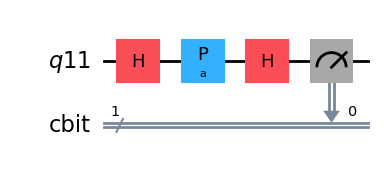

In [18]:
# Apply a hadamard on qubit 0 - this creates equal path case, superposition
# The Hadamard gate can also be expressed as a 90º rotation around the Y-axis, followed by a 180º around the X-axis. 
#
qc.h(0)
# introduce a phase - change the path length. https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseGate
# This is a rotation around the z axis. 
# Make this variable driven, see qiskit parameter, this will be important in a moment. I'm assigning this to the variable a. 
qc.p(Parameter('a'), 0)
# recombine the paths and make a projection for readout on the Z axis.
qc.h(0)
# finally perform a measurement
# qubit 0 results stored in classical register 0
qc_measured = qc.measure(0, 0)
# And make a pretty picture of the circuit.
qc.draw(output='mpl')

In [19]:
# Perform the experiment and loop over the phase angles. 
# Vary the phase parameter (theta) from 0 to pi/2, 1000 points. linspace is a numpy primative. 
theta = np.linspace(0., 4*np.pi, 100)
# Tell the sampler how you want to do the program. 
# qc is the quantum circuit
# theta is the vector of variable parameters for parameter a. 
# The following reference has a very good example on how to use this. 
# https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.primitives.StatevectorSampler
# scroll down to the example where the 'pub' is created. 
#
# pub stands for Primitive unified bloc
# multiple pubs may be submitted. 
# details on pubs - https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output
#
# estimator pubs
# quantum circuit
# A list of one or more observables: [ObservableArrayLike, Pauli, SparsePauliOp, PauliList, str]
# Collection of parameter objects, in this case theta
# 
observables = [SparsePauliOp("Z")]
pub   = (qc, observables, theta)
# Run the job
job = estimator.run([pub])
# get the results
result = job.result()[0] # only 1 qubit

Text(0, 0.5, 'intensity')

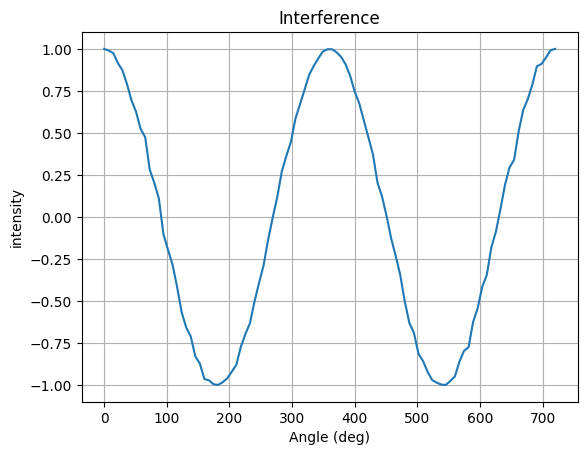

In [20]:
x = 180.0/np.pi * theta
y = result.data.evs
plt.plot(x,y)
plt.grid()
plt.title('Interference')
plt.xlabel('Angle (deg)')
plt.ylabel('intensity')

<H2> Discussion </H2>
The current plot above does not take into account diffraction only interference, this means that the 'intensity' will not vary as 
the system deviates along the measurement point.
<hr> 
<H2> Bloch Sphere</H2>
Qubits can be represented as unit vectors. In reality when we perform operations we manipulate the angles on a sphere. This can be 
graphically shown as a Bloch sphere. In the upcoming plots we show what happens in the circuit. <br> 
<H3> Ground State of system - Initalize </H3>

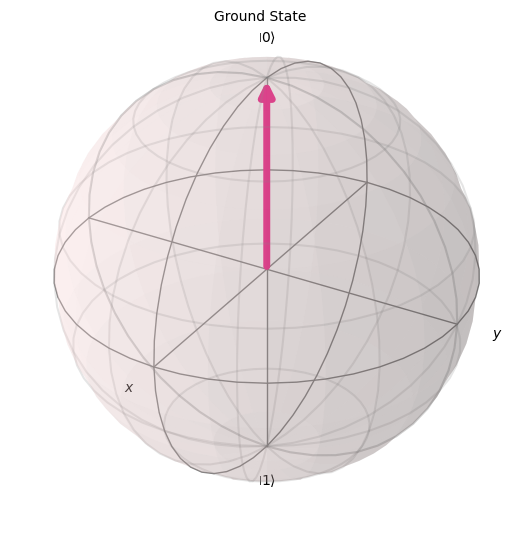

In [29]:
# Ground State of system. 
Vec = [0,0,1]
plot_bloch_vector(Vec, title="Ground State")

[ 1.00000000e+00 -2.46519033e-32 -2.22044605e-16]


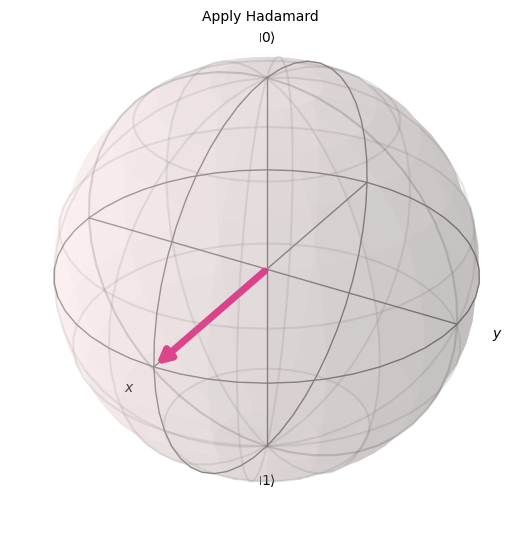

In [30]:
# qubit 0 after H gate. https://docs.quantum.ibm.com/api/qiskit/qiskit.visualization.plot_bloch_vector
# H is a composite of Y(90) followed by X(180)
# Bring the vector the the equator
r_h = R.from_euler('yxz', [[90, 180, 0]], degrees=True)
V2 = r_h.apply(Vec)
print(V2[0])
plot_bloch_vector(V2, title="Apply Hadamard")

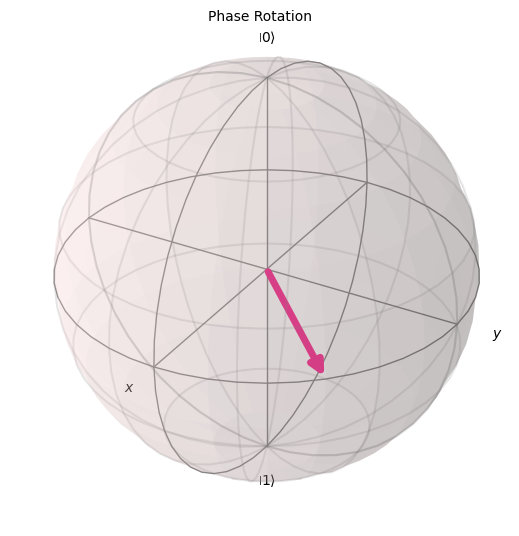

In [31]:
phase = 45
r_ph = R.from_euler('z', phase, degrees=True)
V2 = r_ph.apply(V2)
plot_bloch_vector(V2, title="Phase Rotation")

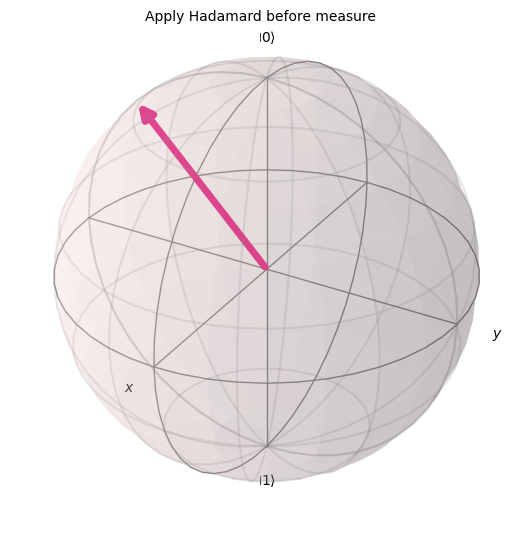

In [32]:
# Apply hadamard before measure
V2 = r_h.apply(V2)
plot_bloch_vector(V2, title="Apply Hadamard before measure")

<H2> Geometric classical interpretation</H2>
This was an experiment on what would happen if we just looked at things from a geometric point of view.
<br> 
<a href="http://hyperphysics.phy-astr.gsu.edu/hbase/phyopt/slits.html#c1"> Reference for two slit experiment </a> <br> 
<br>
Everything is metric and in meters.<br> 
<ul>
    <li> L is the length to the projection screen from the slits. </li>
    <li> s is the distance down the screen from the center point in a list </li>
    <li> d is the distance between the slits. </li>
    <li> r1 is the distance from slit 1 to the point on the screen dictated by s</li>
    <li> r2 is the distance from slit 2 to the point on the screen dictated by s</li>
    <li> Lambda is wavelength of the light impinging on the slits. </li>
    <li> P2 is the power at the screen. ${(r1-r2)\over{\lambda}}$ is the phase difference at the point on the screen. </li>
</ul>
<br> 
What is missing from this is the description of the diffraction caused by the slits. 

Text(0, 0.5, 'intensity')

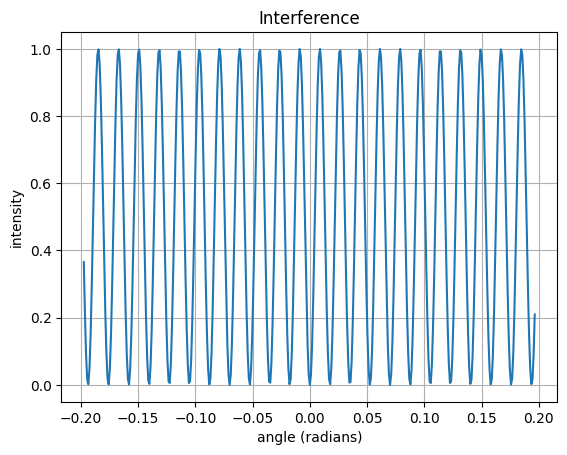

In [53]:
# Distance to screen
L = 0.5       # meters
# angular offset from perpenduclar
s_max  = 0.10 # meters
th_max = np.atan2(s_max,L)
N_steps = 400
step_size = 2*th_max/N_steps
theta  = np.arange(-th_max,th_max,step_size)
# spacing on slits from Centerline
d = 1.0e-5  # meters
s = L * np.tan(theta)
# calculate the two paths. 
r1 = np.sqrt(np.power(s+d,2.0)+np.power(L,2.0))
r2 = np.sqrt(np.power(s-d,2.0)+np.power(L,2.0))
# choose a specific wavelength of light. 
Lambda = 700.0e-9 # red light (meters)
# phase difference in based on wavelength
phase = 2.0*np.pi*(r1-r2)/Lambda
# calculate the intensity. 
P2    = np.power(np.sin(phase), 2.0)
#
plt.plot(theta,P2)
plt.grid()
plt.title('Interference')
plt.xlabel('angle (radians)')
plt.ylabel('intensity')

<H2> adding in diffraction component</H2>
<a href="http://hyperphysics.phy-astr.gsu.edu/hbase/phyopt/mulslid.html#c2"> Diffraction reference. </a>

/var/folders/14/9z9f9pnd13v8hyxk9rn_htc40000gn/T/ipykernel_39293/1750011250.py:3: RuntimeWarning: invalid value encountered in divide
  Diff = np.power(np.sin(phase),2.0)/np.power(phase*2,2.0)


Text(0, 0.5, 'intensity')

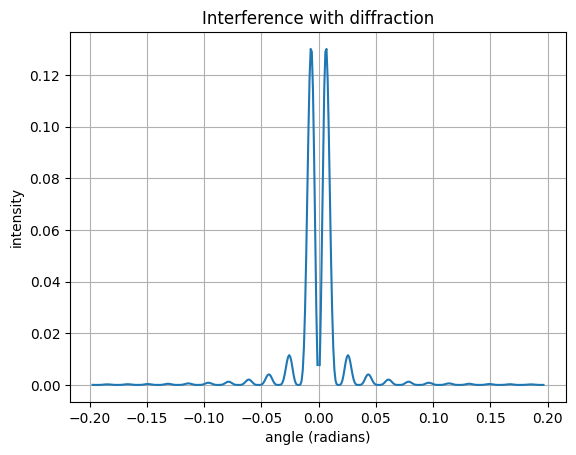

In [57]:
# each path has a intensity modulation due to diffraction
slit_width = 1.0e-5 # meters
Diff = np.power(np.sin(phase),2.0)/np.power(phase*2,2.0)
P3 = np.multiply(P2, Diff)
plt.plot(theta,P3)
plt.grid()
plt.title('Interference with diffraction')
plt.xlabel('angle (radians)')
plt.ylabel('intensity')

<H2> Now lets try doing quantum erasure. </H2>